## Генератор траекторий Геометрического Винеровского процесса

Геометрический Винеровский процесс (далее GBM) - случ. процесс, в котором логарифм случайной величины (сечения) ведёт себя как обычное Броуновское движение (т.е. является Винеровским процессом)


Вывод решения опирается на Лемму Ито, полный вывод можно [найти здесь](https://www.quantstart.com/articles/Geometric-Brownian-Motion/). Он согласется с [формулой из Википедии](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)

Для генерации Винеровского процесса (Броуновского движения) воспользуемся теоремой о том, что оно приближается случайными блужданиями:
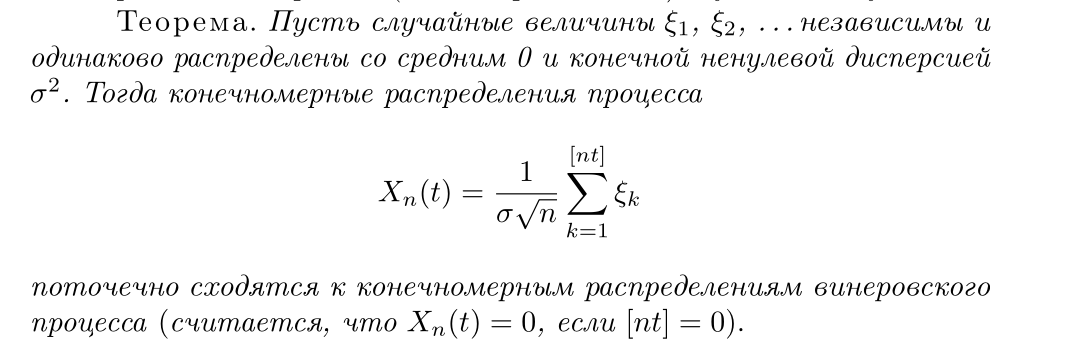

Случайные величины $\xi_i$ будем брать из $\mathcal{N}{(0, 1)}$, потому что эмпирически шум в большинстве случаев нормален. Но дисперсию из теоремы со скрина можно самостоятельно задать параметром `random_walk_scale`

В классе броуновского движения сначала реализуем Винеровский процесс, потом воспользуемся им для реализации GBM.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps

In [62]:
class BrownianMotion:

    def __init__(self, drift=1, var=1, scale=1, iters=1000):
        self.drift_rate = drift  # кф-т дрейфа (кф-т сноса стох. процесса)
        self.variance_rate = var  # кф-т диффузии (дисперсия)
        self.random_walk_scale = scale  # стандартное отклонение для случ. блужданий
        self.n_iter = iters  # количество случ. величин для генерации Броуновского движения

    def random_walk(self, t):
        dt = t / (self.n_iter - 1)
        W = np.zeros(self.n_iter)
        for iter in range(1, self.n_iter):
            ksi_i = sps.norm.rvs(loc=0, scale=self.random_walk_scale)
            W[iter] = W[iter - 1] + ksi_i * np.sqrt(dt)

        return W

    def geometric_brownian_motion(self, S_0, t):
        '''
        Ф-я возвращает аналит. формулу для геом. винеровского процесса
        '''
        time = np.linspace(0, t, self.n_iter)
        return S_0 * np.exp((self.drift_rate - self.variance_rate ** 2 * 0.5) * time + self.variance_rate * self.random_walk(t))

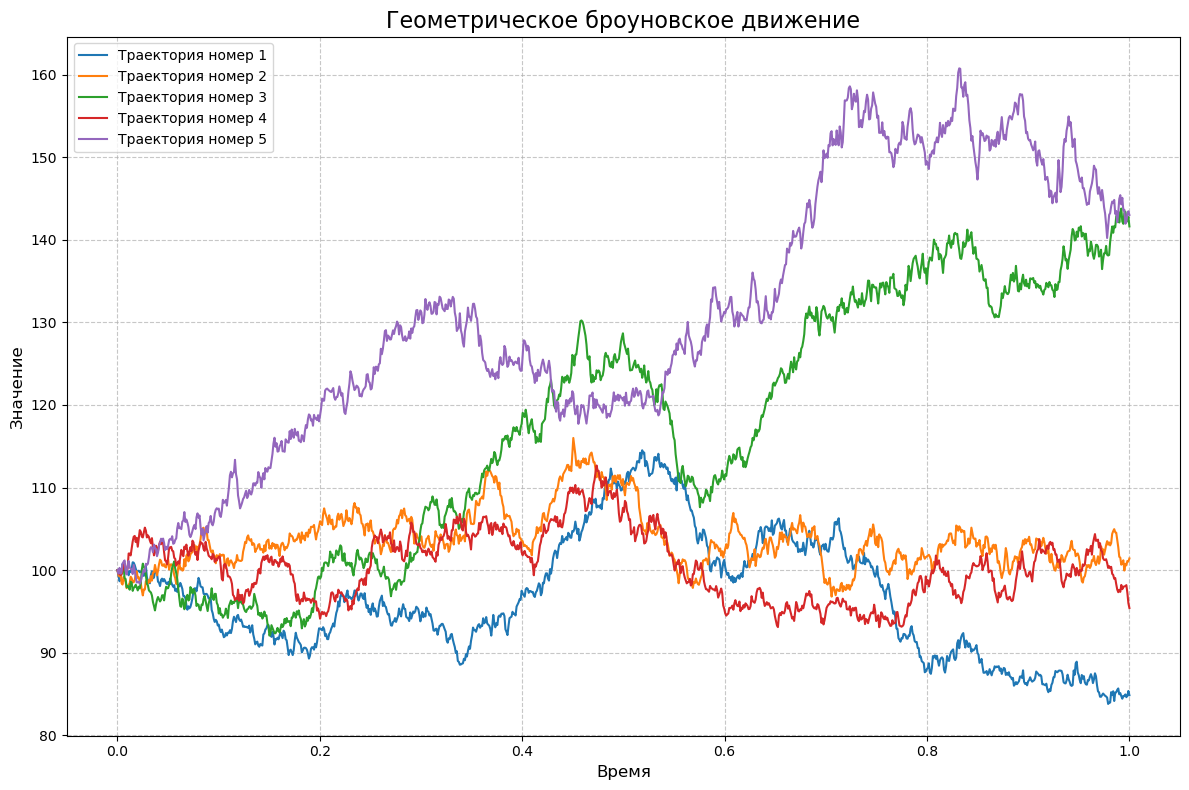

In [64]:
bm = BrownianMotion(drift = 0.1, var = 0.2, scale = 1, iters = 1000)

S_0 = 100
T = 1
num_paths = 5  # кол-во траекторий

t = np.linspace(0, T, bm.n_iter)

trajectories = np.array([bm.geometric_brownian_motion(S_0, T) for _ in range(num_paths)])

plt.figure(figsize = (12, 8))

for i in range(num_paths):
    plt.plot(t, trajectories[i], label=f'Траектория номер {i+1}')

plt.title('Геометрическое броуновское движение', fontsize = 16)
plt.xlabel('Время', fontsize = 12)
plt.ylabel('Значение', fontsize = 12)
plt.legend(fontsize = 10)
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.tight_layout()

plt.show()